In [1]:
import os, sys, copy, shutil, subprocess
import multiprocessing as multi
import pathlib as pl
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import numpy.ma as ma
import fiona
from IPython.display import display, Markdown, Image

In [2]:
## Filenames and fields:
Project_Area = 'Los_Angeles'          # Project area name
GRASS_GIS_Projection = '26911'       #EPSG number

## Load the HUC polygon shapefile and tiff
select_data = '180701050402'     # Value within the filter_field used for data selection
DEM_Res =1             #DEM resolution in meters

## GRASSGIS Location and Mapsets
Location = Project_Area+'_'+GRASS_GIS_Projection
Mapset = 'ML'

jobs =['Local','NonLocal']#

## Paths:
root_dir = pl.Path(os.getcwd())
parent_dir = pl.Path(root_dir.parent)
outputs_dir =parent_dir/'Data/Rasters'/Project_Area/'Outputs'
vector_dir = parent_dir/'Data/Vectors'
raster_dir = parent_dir/'Data/Rasters'/Project_Area

In [4]:
# create GRASS GIS runtime environment
grass7bin = r'C:\Program Files\GRASS GIS 7.8\grass78.bat'
startcmd = [grass7bin, "--config", "path"]

#Define GIS based directory and database (data) storage location
gisbase = subprocess.check_output(startcmd, text=True).strip()
gisdb = os.path.join(os.path.expanduser("~"), "Documents\grassdata")

os.environ['GISBASE'] = gisbase
os.environ['GRASSBIN'] = r'"C:\Program Files\GRASS GIS 7.8\grass78.bat"'

#Append python scripts to system path
grass_pydir = os.path.join(gisbase, "etc", "python")
sys.path.append(grass_pydir)

# do GRASS GIS imports
from grass.script import*
import grass.script as gs
import grass.script.setup as gsetup
import grass.script.array as garray
from grass.pygrass.modules import Module, ParallelModuleQueue

# for the latest development version use:
#pip install git+https://github.com/zarch/grass-session.git
from grass_session import Session
from grass.script import core as gcore

# simply overwrite existing maps like we overwrite Python variable values
os.environ['GRASS_OVERWRITE'] = '1'
# enable map rendering to in Jupyter Notebook
os.environ['GRASS_FONT'] = 'sans'
# set display modules to render into a file (named map.png by default)
os.environ['GRASS_RENDER_IMMEDIATE'] = 'cairo'
os.environ['GRASS_RENDER_FILE_READ'] = 'TRUE'
os.environ['GRASS_LEGEND_FILE'] = 'legend.txt'

#Start GRASS GIS session
rcfile = gsetup.init(gisbase, "data/grassdata", "nc_basic_spm_grass7", "user1")

In [5]:
## Location
GrassGIS_Location = os.path.join(gisdb, Location)
#Location and Mapset
GrassGIS_LocationMapset = os.path.join(gisdb, Location, Mapset)
#Setup database for the project. Need to setup the location first, which builds a permanent folder for mapsets

#Check is the Location is setup. If not setup, create the location for the database
if os.path.exists(GrassGIS_Location):
    print("Database Location Exists")
else:
    with Session(gisdb=gisdb, location=Location, create_opts="EPSG:"+GRASS_GIS_Projection):
        # run something in PERMANENT mapset:
        print(gcore.parse_command("g.gisenv", flags="s"))

if os.path.exists(GrassGIS_Location):
    print("Database Mapset Exists")
else:
    with Session(gisdb=gisdb, location="Des_Plaines", mapset="ML",create_opts=""):
        # do something in the test mapset.
        print(gcore.parse_command("g.gisenv", flags="s"))    
#Check if the Mapset is setup. If not setup, creat the mapset for the database

Database Location Exists
Database Mapset Exists


In [6]:
#GISBASE/etc/clean_temp

folder = pl.Path(gisdb)/Location/'Permanent/.tmp/unknown'
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

Failed to delete C:\Users\mbartlettjr\Documents\grassdata\Los_Angeles_26911\Permanent\.tmp\unknown\31416.0. Reason: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\mbartlettjr\\Documents\\grassdata\\Los_Angeles_26911\\Permanent\\.tmp\\unknown\\31416.0'
Failed to delete C:\Users\mbartlettjr\Documents\grassdata\Los_Angeles_26911\Permanent\.tmp\unknown\31416.1. Reason: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\mbartlettjr\\Documents\\grassdata\\Los_Angeles_26911\\Permanent\\.tmp\\unknown\\31416.1'


In [7]:
# remove old session
os.remove(rcfile)
#Start new session
rcfile = gsetup.init(gisbase,gisdb, Location, 'PERMANENT')
# example calls
print(gs.message('Current GRASS GIS 7 environment:'))
print (gs.gisenv())

None
{'GISDBASE': 'C:\\Users\\mbartlettjr\\Documents\\grassdata', 'LOCATION_NAME': 'Los_Angeles_26911', 'MAPSET': 'PERMANENT'}


In [31]:
#Extensions that need to be installed
extensions = ['r.stream.snap', 'r.stream.distance','r.stream.basins','r.stream.slope', 'r.basins']
#Extentions that are installed
extensions_installed = gs.read_command('g.extension', flags='a').splitlines()
#Install missing extentsions
for extension in extensions:
        if extension not in extensions_installed:
            gs.run_command('g.extension', extension=extension, operation='add')

#View locally installed extensions
gs.parse_command('g.extension', flags ='a')

CalledModuleError: Module run None g.extension extension=r.basins operation=add ended with error
Process ended with non-zero return code 1. See errors in the (error) output.

In [11]:
file_DEM = Project_Area+'_DEM_'+('%sm' % DEM_Res)
file_burned_DEM = select_data+'_%sm_burned_DEM'% DEM_Res
#file_filtered_DEM = select_data+'_%sm_filtered_DEM'% DEM_Res

raster_files = [file_DEM]
vector_files = ['HUC12_Boundaries','v_'+select_data+'_HUC_Boundary', 'NHDPLUS_'+select_data[:4]+'_HU4_GDB']

GRASS_raster_files= [file for line in gs.list_strings(type='raster') for file in [line.split("@")[0]]]
GRASS_vector_files = [file for line in gs.list_strings(type='vector') for file in [line.split("@")[0]]]

In [10]:
#List Existing Files: Vectors and Rasters
gs.message('Available vector maps:')
for vect in gs.list_strings(type='vector'):
    print (vect)


gs.message('Available raster maps:')
for rast in gs.list_strings(type='raster'):
    print (rast)

Los_Angeles_boundingbox@PERMANENT
Los_Angeles_watershed_outlets@PERMANENT
Los_Angeles_watershed_outlets_moved@PERMANENT
NHDPLUS_1807_HU4_GDB@PERMANENT
NHDPLUS_1807_HU4_GDB_select@PERMANENT
v_180701050402_NHDPLUS@PERMANENT
v_Los_Angeles_1m_streams_der_t@PERMANENT
v_Los_Angeles_basins@PERMANENT
180701050402_1m_burned_DEM@PERMANENT
Los_Angeles_1m_accum@PERMANENT
Los_Angeles_1m_draindir@PERMANENT
Los_Angeles_1m_streams_der@PERMANENT
Los_Angeles_1m_streams_der_t@PERMANENT
Los_Angeles_DEM_1m@PERMANENT
Los_Angeles_basins_raster@PERMANENT


In [12]:
if raster_files[0] not in GRASS_raster_files:
    gs.run_command('r.in.gdal', input= outputs_dir/(Project_Area+'_DEM.tif'), output= Project_Area+'_DEM_'+('%sm' % DEM_Res))
    
    
if vector_files[2] not in GRASS_vector_files:
    gs.run_command('v.import', input=  vector_dir/('NHDPLUS_H_'+select_data[:4]+'_HU4_GDB.gdb'), layer ='NHDFlowline',  output= 'NHDPLUS_'+select_data[:4]+'_HU4_GDB')
    #gs.run_command('v.clip', input='NHDPLUS_'+select_data[:4]+'_HU4_GDB', clip='v_'+select_data+'_HUC_Boundary', output= 'v_'+select_data+'_NHDPLUS')  

In [ ]:
region = gs.parse_command('g.region',raster = file_DEM, flags='pg')
gs.parse_command('g.proj', flags='p')

In [ ]:
#gs.parse_command('v.db.select', map='NHDPLUS_'+select_data[:4]+'_HU4_GDB',
#               columns="FType")

#558 is artificial path, 460 is streamriver and 334 is connector
gs.run_command('v.extract', input='NHDPLUS_'+select_data[:4]+'_HU4_GDB',
               where="(FType=558) OR (FType=460) OR (FType=334)", output ='NHDPLUS_'+select_data[:4]+'_HU4_GDB_select')

if 'v_'+select_data+'_NHDPLUS' not in GRASS_vector_files:
    gs.run_command('v.clip', input='NHDPLUS_'+select_data[:4]+'_HU4_GDB_select', flags ='r', output= 'v_'+select_data+'_NHDPLUS')  

In [ ]:
#Burn in NHD flowlines:

#gs.run_command('g.remove', type ='raster', name = [file_burned_DEM], flags ='f')
GRASS_raster_files= [file for line in gs.list_strings(type='raster') for file in [line.split("@")[0]]]

if file_burned_DEM not in GRASS_raster_files:
    gs.run_command('r.carve', raster= file_DEM, vector='v_'+select_data+'_NHDPLUS', width="3", depth="10.0", output= file_burned_DEM)
    print('Created: '+file_burned_DEM)

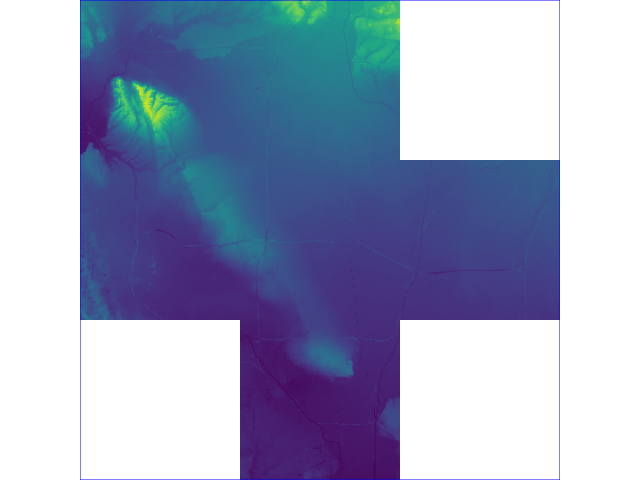

In [13]:
gs.run_command('d.erase')
gs.run_command('d.rast', map=Project_Area+'_DEM_'+('%sm' % DEM_Res) )
gs.run_command('d.vect', map=  Project_Area+'_boundingbox', color="blue")
#gs.run_command('d.vect', map='v_'+select_data+'_HUC_Boundary', type="boundary", color="black", width="3")
Image(filename="map.png")


In [18]:
file_accum = Project_Area+'_%sm_accum'% DEM_Res
file_draindir = Project_Area+'_%sm_draindir'% DEM_Res
Stream_Threshold= 400*90**2
file_streams_der = Project_Area+'_%sm_streams_der'% DEM_Res
file_streams_der_t = Project_Area+'_%sm_streams_der_t'% DEM_Res
file_streams_der_t_v = 'v_'+Project_Area+'_%sm_streams_der_t'% DEM_Res

In [ ]:
#Calculate Watershed Properties for the Burned DEM
#gs.run_command('g.remove', type ='raster', name = [file_accum], flags ='f')
GRASS_raster_files= [file for line in gs.list_strings(type='raster') for file in [line.split("@")[0]]]

#--- Accumulation, Drainage Direction, and Basins
if file_accum not in GRASS_raster_files:
    gs.run_command('r.watershed', elevation=file_burned_DEM, accumulation= file_accum,
                   drainage = file_draindir, flags='sa')
    print('Created: '+file_accum)

In [19]:
gs.mapcalc("%s = if(abs(%s) > %s, 1, null())" 
           %(file_streams_der,
            file_accum, Stream_Threshold))
gs.run_command('r.thin', input=file_streams_der, output= file_streams_der_t, iterations=300)
gs.run_command('r.to.vect', input=file_streams_der_t, output=file_streams_der_t_v, type="line", flags='s')

0

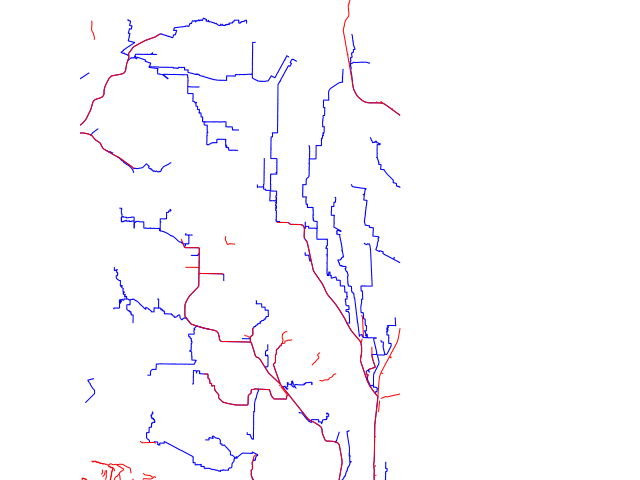

In [22]:
gs.run_command('d.erase')

gs.run_command('d.vect', map= file_streams_der_t_v, color="blue")
gs.run_command('d.vect', map='v_'+select_data+'_NHDPLUS', color="red")
Image(filename="map.png")
Image(filename="map.png")

In [27]:
#Import Coordinates of Interest
gs.run_command('v.in.ascii',input='outlet_point.txt', output=Project_Area+'_watershed_outlets')

CalledModuleError: Module run None v.in.ascii input=outlet_point.txt output=Los_Angeles_watershed_outlets ended with error
Process ended with non-zero return code 1. See errors in the (error) output.

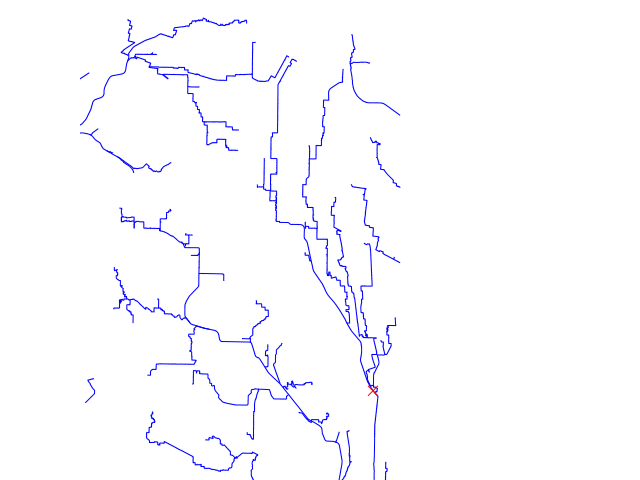

In [28]:
gs.run_command('d.erase')
gs.run_command('d.vect', map= file_streams_der_t_v, color="blue")
gs.run_command('d.vect', map= Project_Area+'_watershed_outlets', color="red", size=10, icon_area ='basic/cross1')
Image(filename="map.png")

In [ ]:
gs.run_command('r.stream.snap',input=Project_Area+'_watershed_outlets', 
               output=Project_Area+'_watershed_outlets_moved',  
               stream_rast=file_streams_der_t, 
               accumulation=file_accum, threshold = 400, radius = 800)

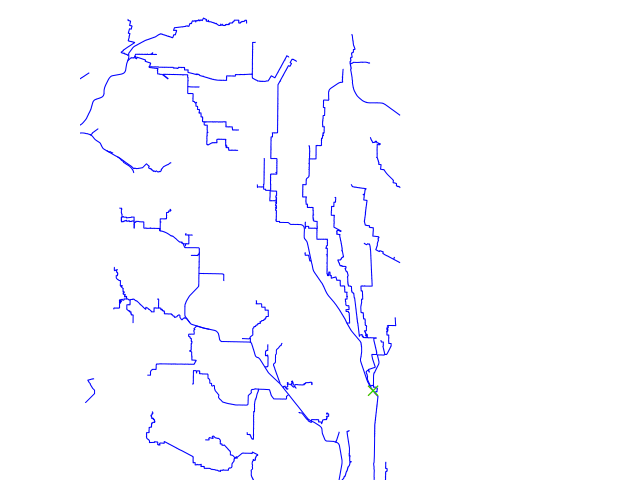

In [29]:
gs.run_command('d.erase')
gs.run_command('d.vect', map= file_streams_der_t_v, color="blue")
gs.run_command('d.vect', map= Project_Area+'_watershed_outlets', color="red", size=10, icon_area ='basic/cross1')
gs.run_command('d.vect', map= Project_Area+'_watershed_outlets_moved', color="green", size=10, icon_area ='basic/cross1')
Image(filename="map.png")

In [ ]:
gs.run_command('r.stream.basins',direction = file_draindir,
               points = Project_Area+'_watershed_outlets_moved',
               basins =Project_Area+'_basins_raster')
gs.run_command('r.to.vect', input=Project_Area+'_basins_raster', output= 'v_'+Project_Area+'_basins', type="area", flags='s')

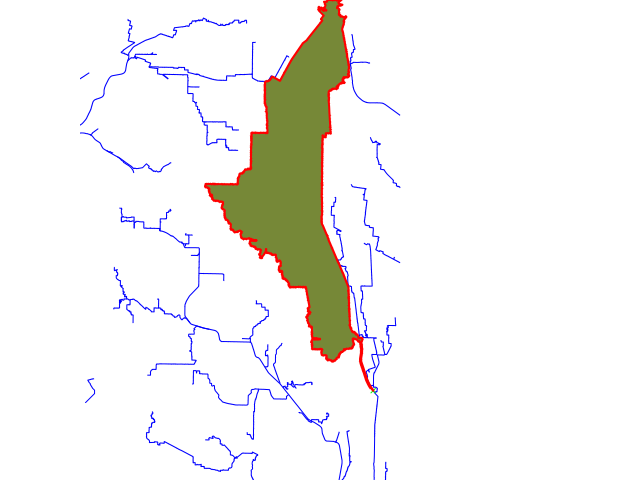

In [30]:
gs.run_command('d.erase')
gs.run_command('d.vect', map= file_streams_der_t_v, color="blue")
#gs.run_command('d.vect', map= Project_Area+'_watershed_outlets', color="black", size=10, icon_area ='basic/cross1')
gs.run_command('d.vect', map= Project_Area+'_watershed_outlets_moved', color="green", size=5, icon_area ='basic/cross1')
gs.run_command('d.rast', map=Project_Area+'_basins_raster' )
gs.run_command('d.vect', map= 'v_'+Project_Area+'_basins', color="red",type="boundary",width="2")
Image(filename="map.png",width=1000)

In [ ]:
gs.run_command('v.out.ogr',input='v_'+Project_Area+'_basins' , output='v_basin.shp', format ='ESRI_Shapefile')

gs.run_command('v.out.ogr',input=Project_Area+'_watershed_outlets' , output='v_outlet.shp', format ='ESRI_Shapefile')

gs.run_command('v.out.ogr',input=Project_Area+'_watershed_outlets_moved', output='v_outlet_moved.shp', format ='ESRI_Shapefile')

gs.run_command('v.out.ogr',input=file_streams_der_t_v, output='v_streams.shp', format ='ESRI_Shapefile')